In [88]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [89]:
users = pd.read_csv('dataset/Users.csv')
ratings = pd.read_csv('dataset/Ratings.csv')
df = pd.merge(users, ratings, on='User-ID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

User-ID        ISBN  Book-Rating
0        2  0195153448            0
1        7   034542252            0
2        8  0002005018            5
3        8  0060973129            0
4        8  0374157065            0

In [90]:
# Ratings distribution

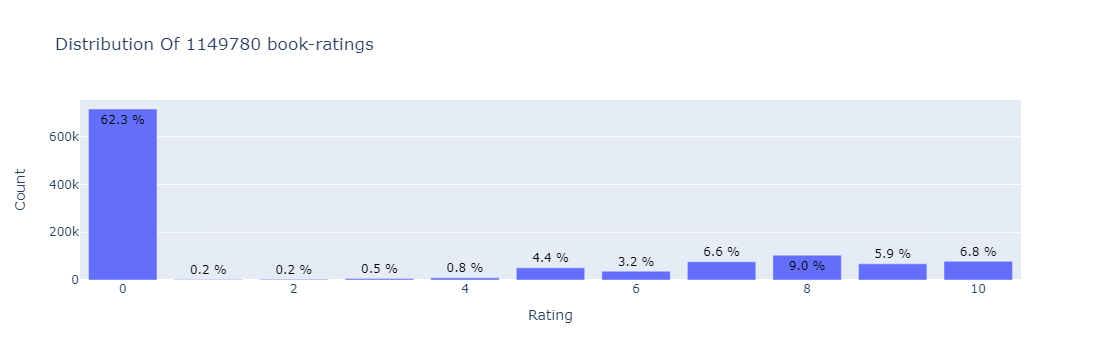

In [91]:

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['Book-Rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [92]:
# Ratings distribution by book

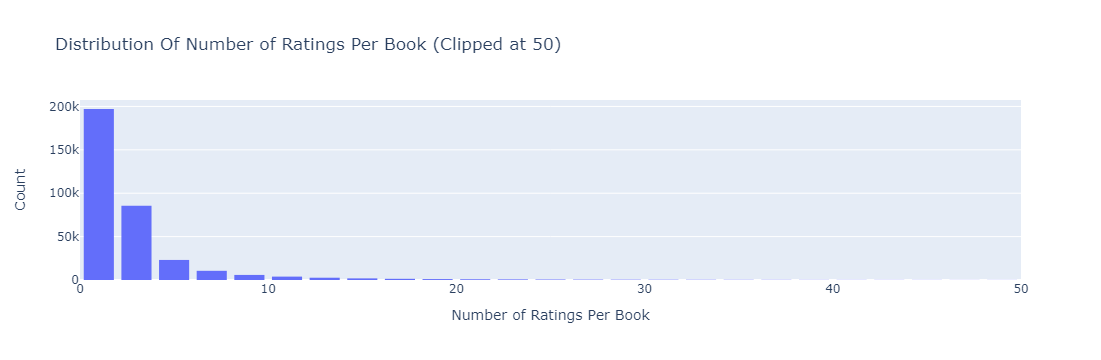

In [93]:

# Number of ratings per book
data = df.groupby('ISBN')['Book-Rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [94]:
df.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False)[:10]

ISBN  Book-Rating
247408  0971880107         2502
47371   0316666343         1295
83359   0385504209          883
9637    0060928336          732
41007   0312195516          723
101670  044023722X          647
166705  0679781587          639
28153   0142001740          615
166434  067976402X          614
153620  0671027360          586

In [95]:
#Ratings distribution by user

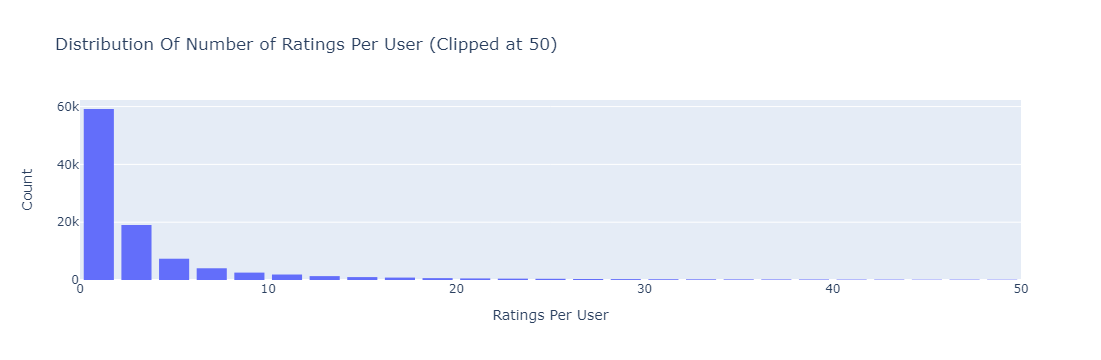

In [96]:
# Number of ratings per user
data = df.groupby('User-ID')['Book-Rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [97]:
df.groupby('User-ID')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False)[:10]

User-ID  Book-Rating
4213      11676        13602
74815    198711         7550
58113    153662         6109
37356     98391         5891
13576     35859         5850
80185    212898         4785
105111   278418         4533
28884     76352         3367
42037    110973         3100
88584    235105         3067

In [98]:
#Reduce dimensionality of the dataset

In [99]:
## Explicit Ratings Dataset
explicit_ratings = df[df['Book-Rating'] != 0]
explicit_ratings = explicit_ratings.reset_index(drop = True)
explicit_ratings.shape
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(explicit_ratings.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(433671, 3)


In [100]:
min_book_ratings = 50
filter_books = explicit_ratings['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = explicit_ratings['User-ID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = explicit_ratings[(explicit_ratings['ISBN'].isin(filter_books)) & (explicit_ratings['User-ID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(explicit_ratings.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(433671, 3)
The new data frame shape:	(13716, 3)


In [101]:
# Surprise

In [102]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_new[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [103]:

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp._append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


test_rmse  fit_time  test_time
Algorithm                                      
SVD               1.539902  0.088320   0.023666
SVDpp             1.543556  0.248315   0.136330
BaselineOnly      1.550539  0.009332   0.012333
CoClustering      1.642817  0.246352   0.015995
KNNBaseline       1.684862  0.037671   0.120342
KNNWithZScore     1.692692  0.072659   0.107977
KNNWithMeans      1.697083  0.039750   0.100319
KNNBasic          1.795958  0.031019   0.093327
SlopeOne          1.810408  0.020660   0.050332
NormalPredictor   2.344092  0.008667   0.016333
NMF               2.596124  0.151672   0.019659

In [104]:
#SVD train and predict

In [105]:
algo = SVD()
trainset, testset = train_test_split(data, test_size=0.25)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.5569


1.5568990519694834

In [106]:
def get_NumUserRatings(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_NumBookRatings(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['UserID', 'ISBN', 'Rating', 'EstRating', 'details'])
df['NumUserRatings'] = df.UserID.apply(get_NumUserRatings)
df['NumBookRatings'] = df.ISBN.apply(get_NumBookRatings)
df['err'] = abs(df.EstRating - df.Rating)
df = df.drop('details', axis=1)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [107]:
best_predictions

UserID        ISBN  Rating  EstRating  NumUserRatings  NumBookRatings  \
2104  241980  0380813815    10.0  10.000000              22              23   
1147  153662  0439139600    10.0  10.000000              37              23   
1007  220688  0439139600    10.0  10.000000              24              23   
2905  234828  0671793489     8.0   7.998465              23              14   
479   136139  014100018X     8.0   8.002045              11              16   
3127  153718  0515128554     8.0   8.002192              13              21   
1438   32773  014025448X     8.0   7.996740               9              10   
234   110912  080410753X     9.0   8.996704              30              19   
2249  232945  0440225701     8.0   7.996344              14              26   
376   164323  0449221482     8.0   8.005126              29              12   

           err  
2104  0.000000  
1147  0.000000  
1007  0.000000  
2905  0.001535  
479   0.002045  
3127  0.002192  
1438  0.003260  
234   0.003296  
2249  0.003656  
376   0.005126

In [108]:
worst_predictions

UserID        ISBN  Rating  EstRating  NumUserRatings  NumBookRatings  \
1975   66942  1573229326     1.0   7.214263              20              17   
3209  162738  0316969680     1.0   7.552097              14               8   
2024  261829  0316776963     1.0   7.564193              33              29   
1928  238889  014028009X     1.0   7.862843              10              42   
848   140036  0316769487     1.0   7.936913               0              43   
10     11676  0440222656     1.0   7.979812             222              20   
2822   83287  0425182908     1.0   8.061576               9              13   
2418  236757  0553250426     1.0   8.095809              16              28   
2083    7158  074343627X     1.0   8.237109              13              12   
1059    6563  0684872153     1.0   8.403469              15              19   

           err  
1975  6.214263  
3209  6.552097  
2024  6.564193  
1928  6.862843  
848   6.936913  
10    6.979812  
2822  7.061576  
2418  7.095809  
2083  7.237109  
1059  7.403469